In [2]:
import matplotlib.pyplot as plt
import numpy as np

# source venv/bin/activate

import librosa
import numpy as np
import soundfile as sf

In [3]:
# Cargar el archivo de audio
y, sr = librosa.load("/Users/belengotz/Desktop/MUSIC_CODE/Copia de Joan Jett - I Love Rock 'n' Roll (lyrics).wav", sr=None)

# Aplicar STFT para obtener una matriz de tiempo-frecuencia
S = librosa.stft(y)

# Separar en componentes armónico (voz) y percutivo (instrumentos)
S_harmonic, S_percussive = librosa.decompose.hpss(S)

# Tomar la magnitud del componente armónico para aplicar SVD
S_magnitude = np.abs(S_harmonic)

# Aplicar SVD a la matriz de magnitudes del componente armónico
U, Sigma, Vt = np.linalg.svd(S_magnitude, full_matrices=False)

# Seleccionar los primeros componentes para reconstruir la voz
k = 5  # Ajusta el número de componentes para aislar la voz
S_vox_magnitude = U[:, :k] @ np.diag(Sigma[:k]) @ Vt[:k, :]

# Reconstruir la señal del componente de voz con la fase original
S_vox = S_vox_magnitude * np.exp(1j * np.angle(S_harmonic))

# Reconstruir las señales de audio de voz y percusión usando la inversa de STFT
y_vox = librosa.istft(S_vox)
y_instr = librosa.istft(S_percussive)

# Aplicar un factor de ganancia (ajustable) para incrementar el volumen
gain_factor = 5  # Ajusta este valor para cambiar el volumen
y_vox = np.clip(y_vox * gain_factor, -1, 1)
y_instr = np.clip(y_instr * gain_factor, -1, 1)

# Guardar los audios resultantes con volumen ajustado
sf.write("voz_separada_svd_con_volumen.wav", y_vox, sr)
sf.write("instrumentos_svd_separados_con_volumen.wav", y_instr, sr)


# 📊 1. Waveform Comparativo
Mostrar la forma de onda original, armónica y percutiva en líneas superpuestas:

/var/folders/j1/r60xxb3967n8vkrdq5glrgzw0000gn/T/ipykernel_70367/2511350479.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


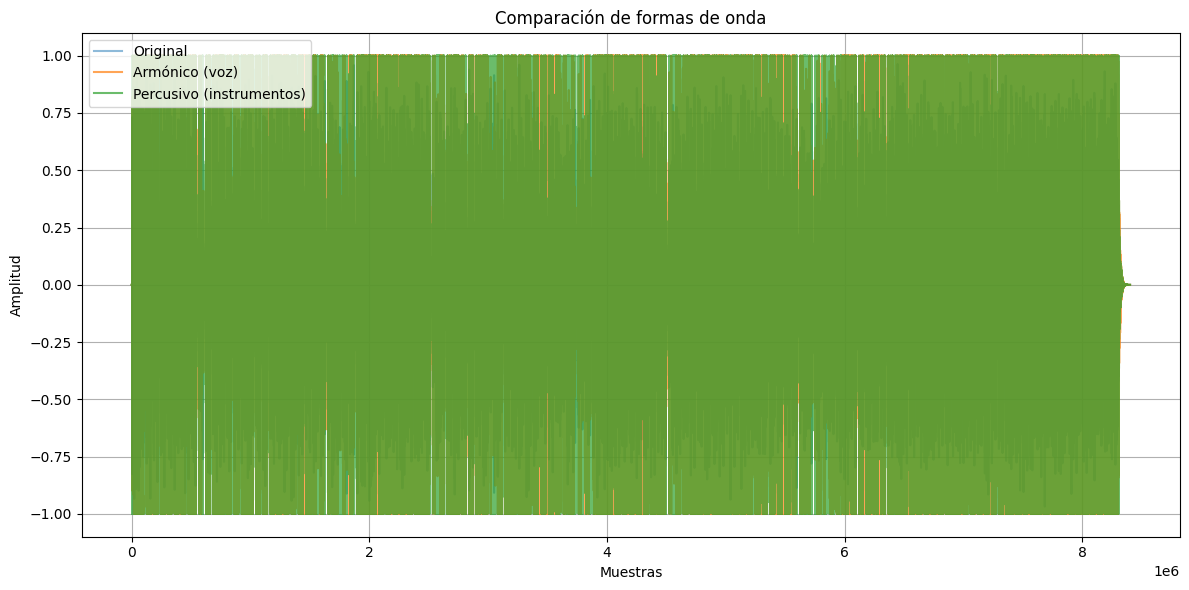

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(y[:len(y_vox)], label="Original", alpha=0.5)
plt.plot(y_vox, label="Armónico (voz)", alpha=0.7)
plt.plot(y_instr, label="Percusivo (instrumentos)", alpha=0.7)
plt.title("Comparación de formas de onda")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Qué muestra:
Superposición de las formas de onda de la señal original, el componente armónico (voz) y el percutivo (instrumentos), todos normalizados.

Significado:
Visualiza cómo la señal completa se puede descomponer en dos partes diferenciadas: la armónica, que sigue las envolventes de notas sostenidas y estructuras melódicas, y la percutiva, que capta los picos de energía breve típicos de la percusión. La señal percutiva domina en amplitud por su naturaleza transitoria.

Pie de foto:
Superposición de las formas de onda original, armónica y percutiva. Se observa una mayor densidad en la señal percutiva, reflejando el predominio de eventos rítmicos breves frente a las estructuras tonales sostenidas de la voz.

# 🌈 2. Chroma Features (Mapas de cromatismo)
Para visualizar la huella armónica (notas) en el tiempo:

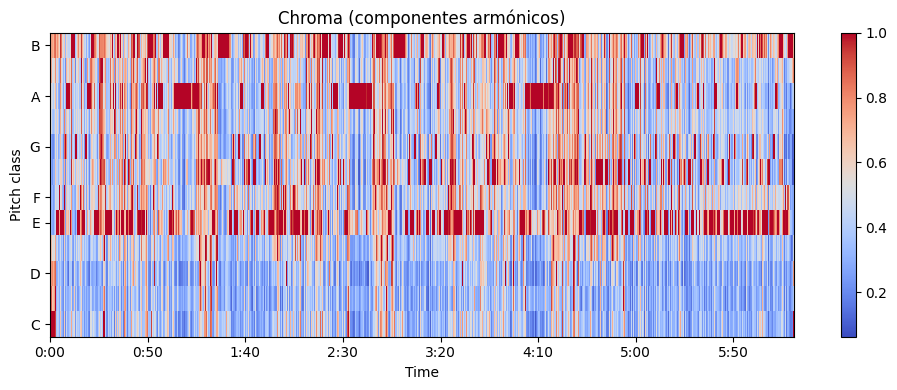

In [11]:
chroma = librosa.feature.chroma_cqt(y=y_vox, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma (componentes armónicos)")
plt.tight_layout()
plt.show()


Qué muestra:
Representación Chroma del componente armónico: intensidad de cada clase de pitch (C a B) a lo largo del tiempo.

Significado:
El Chroma destaca qué notas están presentes en cada instante. En este caso, se observa cómo la melodía recorre diferentes tonalidades, con énfasis variable en notas específicas, lo que permite inferir la progresión armónica de la pieza.

Pie de foto:
Matriz Chroma del componente armónico. La visualización muestra la actividad de cada clase de pitch a lo largo del tiempo, destacando la evolución de la tonalidad y la estructura melódica.

# 🎯 3. Mapas de energía por banda de frecuencia (Spectral Bandwidth)
Visualiza la concentración de energía espectral a lo largo del tiempo:

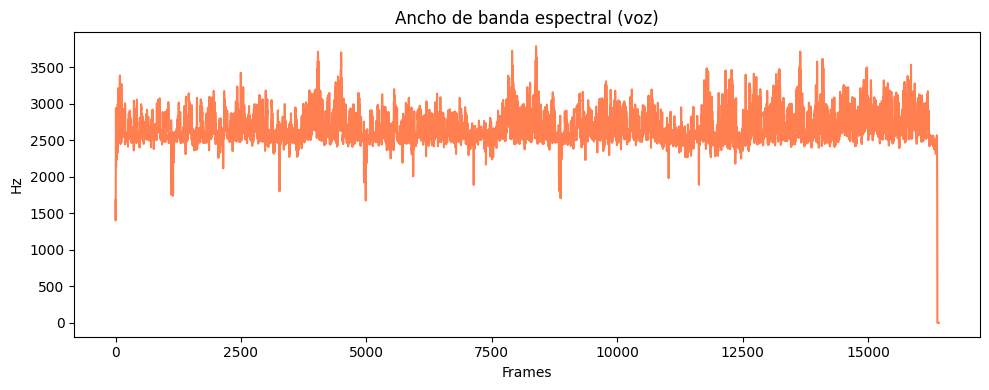

In [ ]:
bandwidth = librosa.feature.spectral_bandwidth(y=y_vox, sr=sr)[0]

plt.figure(figsize=(10, 4))
plt.plot(bandwidth, color='coral')
plt.title("Ancho de banda espectral (voz)")
plt.ylabel("Hz")
plt.xlabel("Frames")
plt.tight_layout()
plt.show()


Qué muestra:
Gráfico del ancho de banda espectral del componente armónico (voz) en función del tiempo.

Significado:
El ancho de banda espectral mide cuán distribuida está la energía en el espectro. Las secciones más anchas corresponden a pasajes vocales más ricos en armónicos, mientras que los tramos más angostos representan notas sostenidas o pausas.

Pie de foto:
Ancho de banda espectral de la voz a lo largo del tiempo. Las variaciones indican fluctuaciones en la riqueza armónica, asociadas a cambios en la expresividad vocal y articulación.

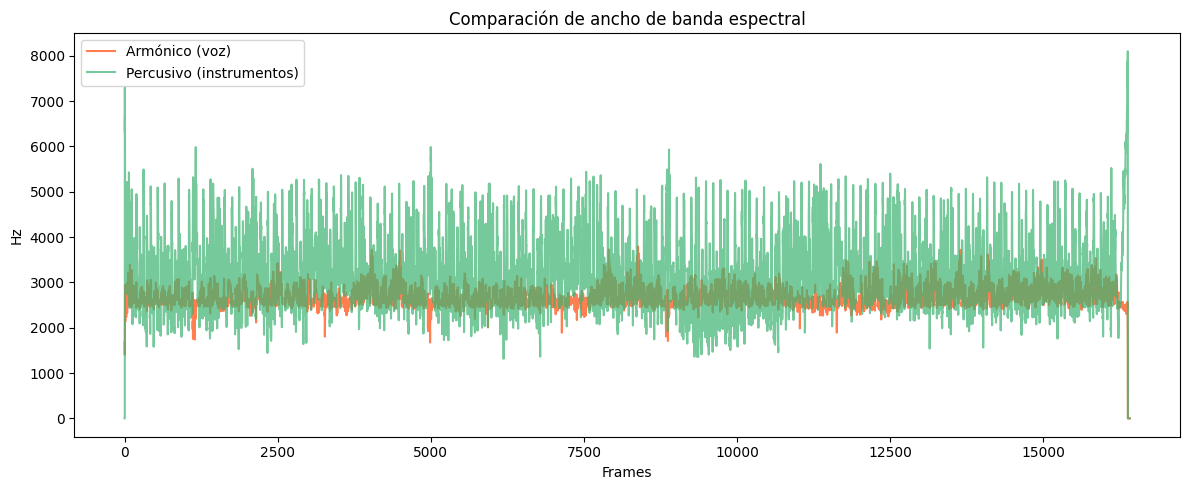

In [12]:
# Extraer ancho de banda espectral de cada componente
bandwidth_vox = librosa.feature.spectral_bandwidth(y=y_vox, sr=sr)[0]
bandwidth_instr = librosa.feature.spectral_bandwidth(y=y_instr, sr=sr)[0]

# Gráfico comparativo
plt.figure(figsize=(12, 5))
plt.plot(bandwidth_vox, label='Armónico (voz)', color='coral')
plt.plot(bandwidth_instr, label='Percusivo (instrumentos)', color='mediumseagreen', alpha=0.7)
plt.title("Comparación de ancho de banda espectral")
plt.ylabel("Hz")
plt.xlabel("Frames")
plt.legend()
plt.tight_layout()
plt.show()


¿Qué podés observar?
El componente percutivo suele tener un ancho de banda más amplio y variable (por sus transientes y ataques fuertes).
El componente armónico presenta un ancho de banda más estable, acorde con las notas sostenidas o frases melódicas.

# ⚡ 4. RMS Energy Over Time
Ideal para detectar la dinámica de intensidad:

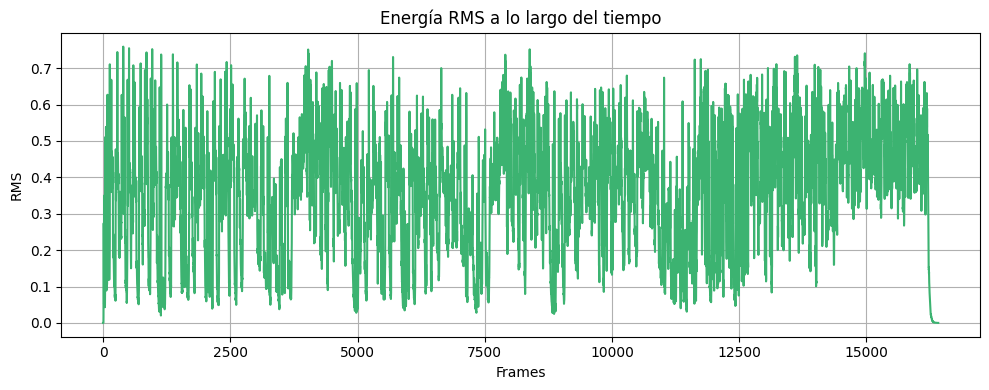

In [7]:
rms_vox = librosa.feature.rms(y=y_vox)[0]
plt.figure(figsize=(10, 4))
plt.plot(rms_vox, label="Energía RMS - Voz", color='mediumseagreen')
plt.title("Energía RMS a lo largo del tiempo")
plt.xlabel("Frames")
plt.ylabel("RMS")
plt.tight_layout()
plt.grid()
plt.show()


Qué muestra:
Representación de la energía RMS (Root Mean Square) del componente armónico (voz) a lo largo de los frames temporales.

Significado:
Refleja la intensidad sonora en cada instante. Altos valores indican frases vocales prominentes; los bajos valores coinciden con silencios o sonidos suaves.

Pie de foto:
Curva de energía RMS del componente armónico. La dinámica de la interpretación vocal se hace visible a través de los picos y valles, evidenciando momentos de énfasis y reposo.

# 🔍 5. Diagrama de dispersión: Centroide vs RMS
Relación entre timbre y energía para ambos componentes:

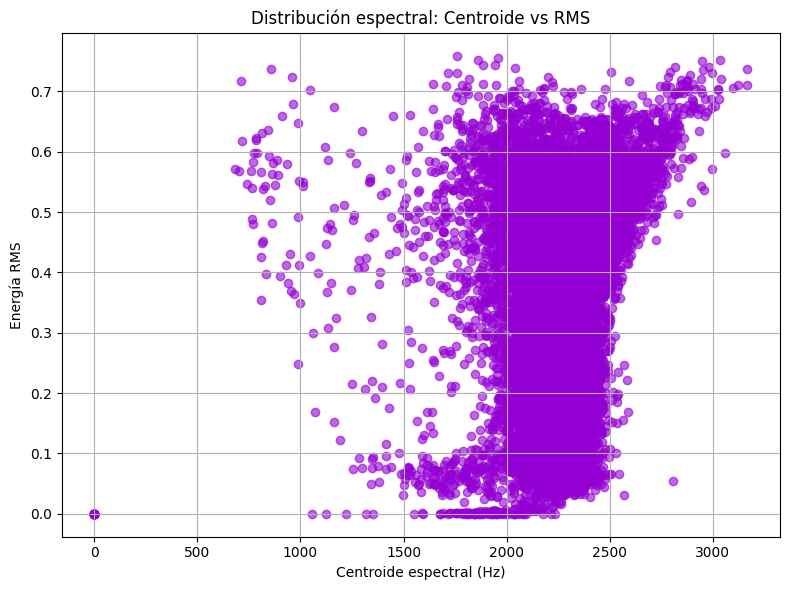

In [8]:
centroid_vox = librosa.feature.spectral_centroid(y=y_vox, sr=sr)[0]
plt.figure(figsize=(8, 6))
plt.scatter(centroid_vox, rms_vox, alpha=0.6, color='darkviolet')
plt.xlabel("Centroide espectral (Hz)")
plt.ylabel("Energía RMS")
plt.title("Distribución espectral: Centroide vs RMS")
plt.grid()
plt.tight_layout()
plt.show()


Qué muestra:
Gráfico de dispersión entre el centroide espectral (frecuencia promedio) y la energía RMS.

Significado:
Permite correlacionar la "brillantez" (centroide alto) con la intensidad. Las regiones con alta energía y centroide medio representan pasajes vocales bien proyectados, mientras que los puntos con centroide bajo y energía baja corresponden a sonidos más graves o apagados.

Pie de foto:
Diagrama de dispersión entre el centroide espectral y la energía RMS. La distribución revela la relación entre intensidad y riqueza espectral de los pasajes vocales, proporcionando una huella sonora del timbre y dinámica.